## Task 2


### Prepare 4 random 4-qubit quantum states of your choice.

Create and train a variational circuit that transforms input states into predefined output states. Namely

if random state 1 is provided, it returns state |0011>

if random state 2 is provided, it returns state |0101>

if random state 3 is provided, it returns state |1010>

if random state 4 is provided, it returns state |1100>

What would happen if you provided a different state?

Analyze and discuss the results.

### I have solved this classification problem using a Quantum Support Vector Machine

#### A Brief Intro to Quantum Support Vector Machines:

##### 1) What is a Support Vector Machine?

A support vector machine is a supervised machine learning method that is trained using a dataset and will predict if a particular observation is in a certain class based upon what it has been trained on. It is similar to a linear classifier which uses a hyperplane to separate classes. However along with the hyperplane support vectors are used. These are essentially data points that are used to maximise the margin and thus the distance between the classes. 

However the Quantum Support Vector Machine is different from a Classical Support Vector Machine.

##### 2) What is a Quantum Support Vector Machine(QSVM)?

The Quantum Support Vector Machine is different from a Classical Support Vector Machine. It uses a feature map to map data points to a quantum circuit.  

##### Steps to Build a Quantum Support Vector Machine:-

1) Prepare your dataset and split it into the appropriate Training and Testing ratio.

2) Encode the training data in a Feature Map .

3) Prepare the train and test kernel matrices from the Feature Map circuit.

4) Test your Quantum Kernel matrices on Classical Classifiers.

5) Compare the QSVM Kernel Classification results with a Classical SVM.

##### Where do I see the real Quantum process in a QSVM?

Encoding the data via a Feature Map in a Quantum Circuit is what makes the QSVM really "Quantum" instead of a classical simulation.

### So, Let's Start

### Importing the necessary libraries

In [1]:
# General Imports
import numpy as np

# Visualisation Imports
import matplotlib.pyplot as plt

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Pandas Imports
import pandas as pd

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

`output_state` is a simple function that acts as a mapper. It is basically mapping the parameters given in the Task Question.

1 ---> 0011

2 ---> 0101

3 ---> 1010

4 ---> 1100

Any other digit like 6-9 ---> None

In [2]:
def output_state(x):
    if x == 1:
        return '0011'
    elif x == 2:
        return '0101'
    elif x == 3:
        return '1010'
    elif x == 4:
        return '1100'
    else:
        return 'None'

`decimaltoBinary` is a simple function that converts a Decimal number to a Binary number.

In [3]:
def decimalToBinary(n):
    return bin(n).replace("0b", "")
   
if __name__ == '__main__':
    print(decimalToBinary(8))

1000


### Preparation of the dataset

#### The Features and labels of this Dataset:-

1) Input State - Generate 150 random input output states with digits ranging from 0-9.

2) Binary State - Converts the Input decimal digits to binary by our `decimaltoBinary` function.

3) Counter - This is a variable that simply assigns it's value as 1 if the state 1,2,3 or 4 is present otherwise a value of 0 is assigned.

4) Output - The states that we get by our `get_output` function.


#### Dummy Variables and One Hot Encoding

I will be using a ZZFeature map to encode my data in further steps. But, the ZZFeature map needs at least 2 qubits meaning we need to have at least two features in our dataset to make use of the ZZFeature map.

Here,

1) Binary State is the Dummy Variable which is simply derived from the first feature, the Input State.

2) Counter is the One Hot Encoding variable for which I have used the simple One Hot Encoding function.

In [7]:
#Input State
input_states = [] 
for i in range(150):
    ele = np.random.randint(0, 10)
    input_states.append(ele) 

#Binary State
binary_states = []
for i in input_states:
    bv = decimalToBinary(i)
    binary_states.append(bv)

#Counter
counter = [1 if i in [1, 2, 3, 4] else 0 for i in input_states] #One Hot Encoding function

#Output
output = [] 
for i in input_states:
    elem = output_state(i)
    output.append(elem)
df = pd.DataFrame({'Input State': input_states,'Binary State':binary_states,'Counter':counter,'Output': output})
df.head()

,Input State,Binary State,Counter,Output
0,4,100,1,1100
1,2,10,1,0101
2,5,101,0,None
3,1,1,1,0011
4,7,111,0,None


### Splitting the dataset into half for data visualization purposes

In [36]:
df0 = df[:75]
df1 = df[:150]

### Data Visualization using Matplotlib

Plotting our features to find a relation between them

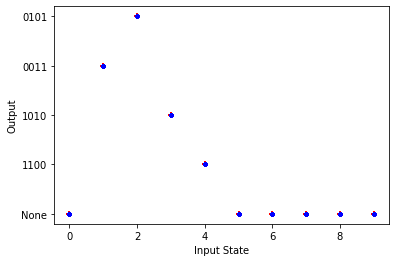

In [38]:
plt.xlabel('Input State')
plt.ylabel('Output')
plt.scatter(df0['Input State'], df0['Output'],color="red",marker='+')
plt.scatter(df1['Input State'], df1['Output'],color="blue",marker='.')

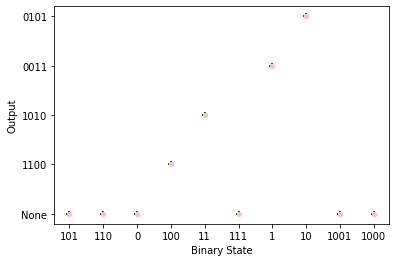

In [40]:
plt.xlabel('Binary State')
plt.ylabel('Output')
plt.scatter(df0['Binary State'], df0['Output'],color="green",marker='+')
plt.scatter(df1['Binary State'], df1['Output'],color="pink",marker='.')

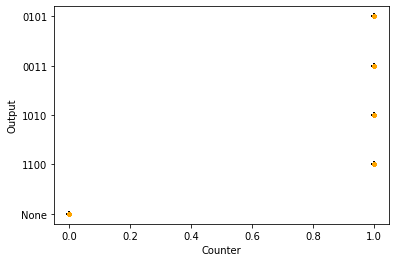

In [42]:
plt.xlabel('Counter')
plt.ylabel('Output')
plt.scatter(df0['Counter'], df0['Output'],color="black",marker='+')
plt.scatter(df1['Counter'], df1['Output'],color="orange",marker='.')

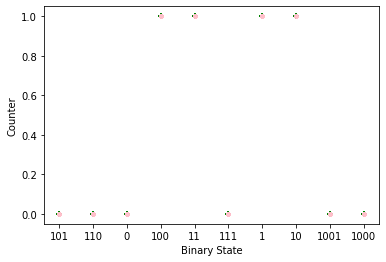

In [43]:
plt.xlabel('Binary State')
plt.ylabel('Counter')
plt.scatter(df0['Binary State'], df0['Counter'],color="green",marker='+')
plt.scatter(df1['Binary State'], df1['Counter'],color="pink",marker='.')

As you can see every feature is Overlapping with each other.

### Splitting the Dataset into training and testing sets by using the `train_test_split` function in sklearn

There are a total of 150 datapoints in the dataset. Each element is an integer between 0 and 9. As per classical classification, we need to split the dataset into training (120) and testing (30) samples i.e. 20% test and 80% training , and normalise it using the Standard Scalar. To use the dataset for quantum classification, we need to scale the range to between -1 and 1. We  also label all of the datapoints by label_train and label_test variables.

In [28]:
sample_train, sample_test, label_train, label_test = train_test_split(df[['Input State','Binary State','Counter']], df['Output'],test_size=0.2,
                                                                      random_state=42)

# Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Select
train_size = 120

label_train = label_train[:train_size].tolist() #Converting the data into a list

test_size = 30
sample_test = sample_test[:test_size]
label_test = label_test[:test_size].tolist()

The data arrays constructed from the features in the dataset

In [30]:
print(sample_train,label_train)
print(sample_test,label_test)

[[ 1.          1.         -1.        ]
 [-0.55555556 -0.98001998  1.        ]
 [-0.77777778 -0.998002    1.        ]
 [-1.         -1.         -1.        ]
 [ 0.55555556 -0.77822178 -1.        ]
 [-0.11111111 -0.8001998   1.        ]
 [-1.         -1.         -1.        ]
 [ 0.11111111 -0.7982018  -1.        ]
 [-0.11111111 -0.8001998   1.        ]
 [ 0.55555556 -0.77822178 -1.        ]
 [ 0.55555556 -0.77822178 -1.        ]
 [ 0.33333333 -0.78021978 -1.        ]
 [-1.         -1.         -1.        ]
 [-1.         -1.         -1.        ]
 [ 0.33333333 -0.78021978 -1.        ]
 [ 0.77777778  0.998002   -1.        ]
 [-1.         -1.         -1.        ]
 [ 0.77777778  0.998002   -1.        ]
 [-1.         -1.         -1.        ]
 [ 0.33333333 -0.78021978 -1.        ]
 [-0.55555556 -0.98001998  1.        ]
 [-0.77777778 -0.998002    1.        ]
 [-0.55555556 -0.98001998  1.        ]
 [ 0.11111111 -0.7982018  -1.        ]
 [-0.55555556 -0.98001998  1.        ]
 [-0.33333333 -0.97802198

### Data Encoding

We will take the classical data and encode it to the quantum state space using a quantum feature map. 

### Quantum Feature Maps

As the name suggests, a quantum feature map $\phi(\mathbf{x})$ is a map from the classical feature vector $\mathbf{x}$ to the quantum state $|\Phi(\mathbf{x})\rangle\langle\Phi(\mathbf{x})|$. This is facilitated by applying the unitary operation $\mathcal{U}_{\Phi(\mathbf{x})}$ on the initial state $|0\rangle^{n}$ where n is the number of qubits being used for encoding.


There are three feature maps currently available in Qiskit:-

1) PauliFeatureMap

2) ZFeature Map

3) ZZFeature Map

Out of these the PauliFeatureMap and ZFeatureMap are simple to simulate classically and do not provide any quantum advantage due to the lack of quantum entanglement, while the ZZFeatureMap having entanglement is the most suitable one to use here for our QSVM.


The `NLocal` and `TwoLocal` functions in Qiskit's circuit library can also be used to create parameterised quantum circuits as feature maps or you can even create your own feature map by the `ParameterVector` function but ensure you create parameterized circuits of alternating rotation and entanglement layers to see a quantum advantage.


So, I will be using the ZZFeatureMap here

In [31]:
zz_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='linear', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))

Encoding the first two training samples in our quantum circuit

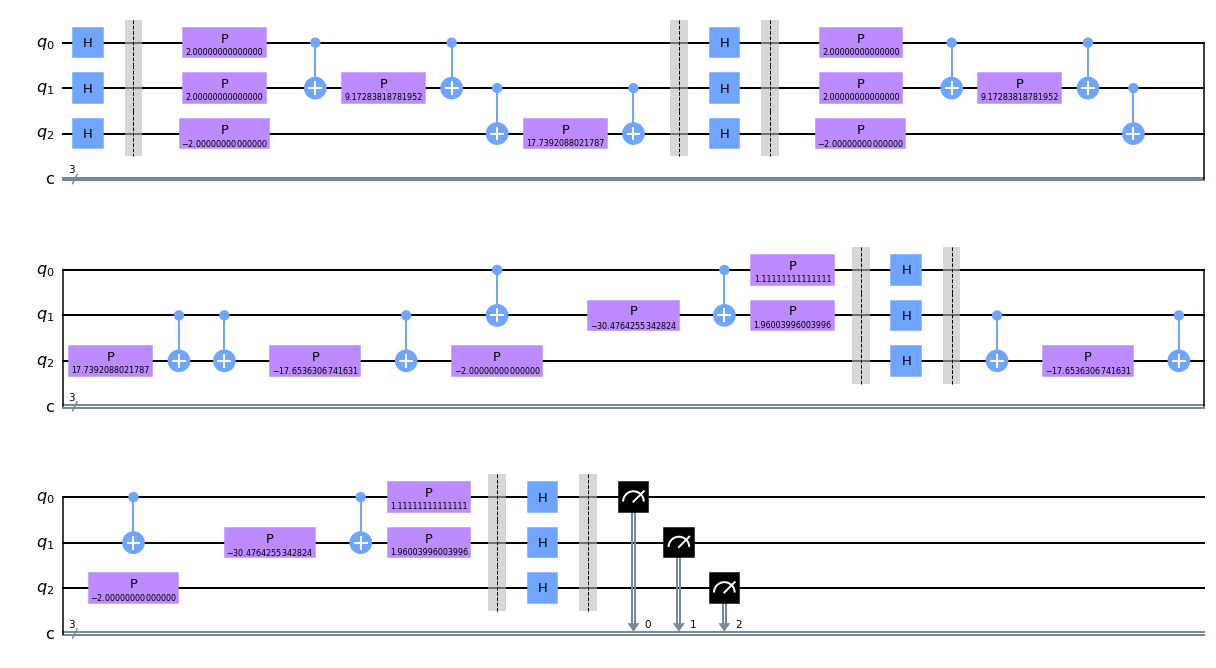

In [32]:
zz_circuit = zz_kernel.construct_circuit(sample_train[0],sample_train[1])
zz_circuit.decompose().decompose().draw(output='mpl')

We then simulate the circuit by defining the backend. We will use the `qasm_simulator` since the circuit contains measurements, but increase the number of shots to reduce the effect of sampling noise.

In [33]:
backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(zz_circuit)

Plotting a histogram to visualize the amplitudes.

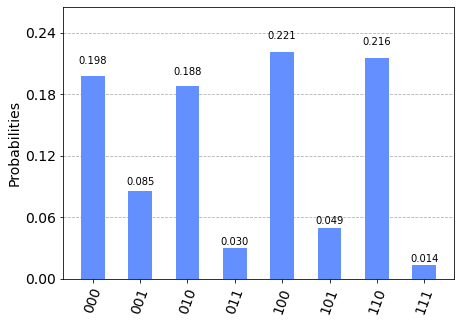

In [51]:
plot_histogram(counts)

#### Computing and plotting the training and testing kernel matrices

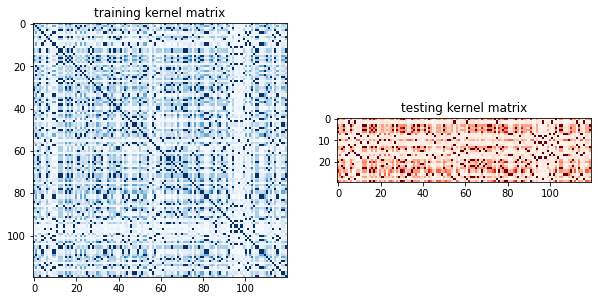

In [52]:
matrix_train = zz_kernel.evaluate(x_vec=sample_train)
matrix_test = zz_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

#### What are these Kernels?

SVM algorithms use a group of mathematical functions that are known as kernels. The function of a kernel is to require data as input and transform it into the desired form. The kernel functions return the scalar product between two points in an exceedingly suitable feature space. Thus by defining a notion of resemblance, with a little computing cost even in the case of very high-dimensional spaces.

### Here we calculate our QSVM Kernel Classification Score with the help of our training and testing kernel matrices

I have used 4 classical kernels:-

1) Linear Kernel 

2) Polynomial Kernel 

3) Gaussian Radial Basis Function Kernel 

4) Sigmoid Kernel 

In [53]:
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in classical_kernels:
    zzpc_svc = SVC(kernel=kernel,C=10,gamma=100)
    zzpc_svc.fit(matrix_train, label_train)
    zzpc_score = zzpc_svc.score(matrix_test, label_test)

    print('%s kernel classification test score:  %0.2f' % (kernel, zzpc_score))

linear kernel classification test score:  1.00
poly kernel classification test score:  1.00
rbf kernel classification test score:  1.00
sigmoid kernel classification test score:  0.63


Here we calculate the Kernel Classification Score for our Classical SVM  by using the same 4 kernels

In [54]:
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in classical_kernels:
    classical_svc = SVC(kernel=kernel,C=10,gamma=100)
    classical_svc.fit(sample_train, label_train)
    classical_score = classical_svc.score(sample_test, label_test)

    print('%s kernel classification test score:  %0.2f' % (kernel, classical_score))

linear kernel classification test score:  1.00
poly kernel classification test score:  1.00
rbf kernel classification test score:  1.00
sigmoid kernel classification test score:  0.77


## Results and Analysis:- 

As you can see the Kernel Classification test scores for both the Classical SVM and QSVM is quite similar. For example, the linear, poly and rbf kernel have an exactly similar score while the sigmoid kernel classification test score is a little different. So, we have successfully managed to bring some similar results between a QSVM and a Classical SVM, which makes the QSVM suitable for real world use.

### Is the Kernel Classification Score good?

Although, one might think a score of 1(100% probability of predicting classification) is good, but in ML a model with a 100% score is considered a bad model and it is due to the following reasons:-

1) **Overfitting of data in the model** - Putting or feeding a lot of data to the model is like spoonfeeding it to find a result, the model will never learn to predict results on new data. The ML models used in the real world need to have the ability to predict the outcome on new data.

2) **Simple Dataset** - The dataset we actually use has one feature and 2 dummy features which are derived from the first feature. So, it means that the 2 dummy features are dependent on the first feature and do not add much value to the model. The functions get_output() and decimaltoBinary() made it easier for the model to predict the results.

3) **Improper Train-Test-Split ratio** - In this case we used a 80% training and 20% testing ratio for our dataset perhaps we can try to use a higher test ratio and lower training ratio. This ratio needs to be right as this is also one of the reasons for overfitting of data.

4) **Hardware Noise**

### Possible ways to fix our model:-

1) We can prevent overfitting by feeding a higher ratio of digits 1,2,3,4,5 to the model and making it predict the 'None' output state on 6,7,8,9 respectively. It will learn how to predict by only feeding a small amount of digits 6-9 in our training set. We can even use the cross validation technique.

2) For the sake of this task, I used a pretty simple model. But, if we use a little more complex dataset like iris or boston housing dataset the model will learn better as these two datasets contain a lot of independent features.

### Conclusion:

We managed to show how a QSVM can be used to for classification of data and have also done a comparison of results between the QSVM and Classical SVM. We have also successfully managed in proving the feasability of Quantum Support Vector Machines in the real world. There are also a plethora of alternatives to using an SVM method; quantum generated features created from the encoding gates explored here could be passed to another classical or quantum classifying algorithm. Whether the same encoding circuits that performed well for the QSVM also succeed in other approaches would be a question for further investigation.

## References:

- 1) **A special thanks to Qiskit Global Summer School 2021**

- 2) **Introduction to Quantum Support Vector Machines:**: https://medium.com/@patrick.huembeli/introduction-into-quantum-support-vector-machines-727f3ccfa2b4

- 3) **Quantum support vector machine for big data classification**: https://arxiv.org/abs/1307.0471

- 4) **Quantum Support Vector Machines for Continuum Suppression in B Meson Decays**: https://arxiv.org/abs/2103.12257

- 5) **Quantum-Inspired Support Vector Machine**: https://arxiv.org/abs/1906.08902

- 6) **Supervised learning with quantum-enhanced feature spaces** - https://www.nature.com/articles/s41586-019-0980-2